In [287]:
import pandas as pd
from sklearn.preprocessing import Normalizer
import xgboost as xgb

In [288]:
from libs.predictor_util import modelfit
from libs.plot_utils import plot_confusion_matrix, analysing_feature_importance
from libs.transformer_utils import process_features_standardisation, encode_labels, one_hot_encode_field

## 1. Load the Data set

In [289]:
df = pd.read_csv('../data/outputs/06_final_dataset.csv')

In [290]:
df.head()

,resultId,raceId,driverId,constructorId,grid,race_rank,statusId,year,round,circuitId,...,race_end_in_2019,race_end_in_2020,race_end_in_2021,race_end_in_2022,race_end_in_2023,driver_most_won_circuit_id,driver_nber_of_races_won,driver_nber_of_times_in_top_10,age,season_age
0,1,18,1,1,1,2,1,2008,1,1,...,21,16,21,19,12,14,63,292,39,23
1,2,18,2,2,5,3,1,2008,1,1,...,0,0,0,0,0,2,2,131,47,31
2,3,18,3,3,7,5,1,2008,1,1,...,0,0,0,0,0,3,20,158,39,23
3,4,18,4,4,11,7,1,2008,1,1,...,0,0,11,12,12,9,22,285,43,27
4,5,18,5,1,3,1,1,2008,1,1,...,0,0,0,0,0,1,2,37,43,27


In [291]:
df.shape

(26080, 28)

In [292]:
df_rank_zero = df[(df['race_rank'] == 0) & (df['year'] > 2008)]
print(df_rank_zero.shape)
df = df[df['race_rank'] != 0]
df = pd.concat([df, df_rank_zero], ignore_index=True)

(261, 28)


In [293]:
# to_one_enc = ['grid', 'statusId']
to_one_enc = ['grid']

In [294]:
for field in to_one_enc:
    df = one_hot_encode_field(df, field)

## 2. Encode categorials variables

In [295]:
cat_cols = ['race_rank', 'constructorId', 'driverId', 'driver_most_won_circuit_id', 'circuitId', 'statusId']

In [296]:
df = encode_labels(df, cat_cols)

## 3. Normalizing columns

In [297]:
cols = ['year', 'constructor_avg_point', 'driver_avg_point', 'constructor_races_won', 'race_end_bf_2019', 
        'race_end_in_2019', 'race_end_in_2020', 'race_end_in_2021', 'race_end_in_2022', 'race_end_in_2023', 'driver_nber_of_races_won', 
        'driver_nber_of_times_in_top_10', 'age']
df[cols] = process_features_standardisation(df, cols, Normalizer)

In [298]:
bins = [df['driver_avg_speed'].min(), 200, 202, 204, 206, df['driver_avg_speed'].max()]
labels = [1, 2, 3, 4, 5]
categories = pd.cut(df['driver_avg_speed'], bins=bins, labels=labels, include_lowest=True)
df['driver_avg_speed'] = categories

## 4. Delete unused columns

In [299]:
df.drop(['raceId', 'resultId', 'age'], axis=1, inplace=True)

In [300]:
df_to_predict_later = df.iloc[:15]
df = df.iloc[16:]
df.head()


,driverId,constructorId,race_rank,statusId,year,round,circuitId,constructor_is_active,constructor_races_won,constructor_avg_point,...,grid_15,grid_16,grid_17,grid_18,grid_19,grid_20,grid_21,grid_22,grid_23,grid_24
16,21,10,8,1,0.989410,1,0,0,0.000000,0.000506,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17,7,5,2,0,0.984106,2,1,1,0.045088,0.002129,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18,8,1,6,0,0.999090,2,1,0,0.000995,0.001095,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19,4,0,7,0,0.999102,2,1,1,0.024878,0.001674,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20,14,6,8,0,0.995004,2,1,0,0.001487,0.000493,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 5. Fit the model

In [301]:
target = 'race_rank'
id_col = 'resultId'
features = [x for x in df.columns if x not in [target, id_col]]

In [302]:
xgb_model = xgb.XGBClassifier(
    n_estimators=205,
    learning_rate=0.001,
    max_depth=120,
    eta= 0.18,
    subsample= .8,
    colsample_bytree= 0.8,
    objective= 'multi:softmax',
    eval_metric='merror',
    min_child_weight = 9,
    gamma = 0,
    n_jobs=-1,
    num_class= 25,
    enable_categorical=True,
    seed=80
)
# best_params = {'colsample_bytree': 0.8, 'eta': 0.01, 'learning_rate': 0.05, 'max_depth': 12, 'n_estimators': 205, 'objective': 'multi:softmax', 'seed': 80, 'subsample': 0.5}

In [303]:
model = modelfit(df, features, target, xgb_model)


Model Report
Accuracy : 0.1399
AUC Score (Train): 0.863643
AUC Score (Test): 0.769053


## 6. Analysing the model output

### 6.1. Classification report

In [304]:
print("Classification Report:")
print(model[4])

Classification Report:
              precision    recall  f1-score   support

           0       0.34      0.78      0.47        67
           1       0.21      0.39      0.28        98
           2       0.26      0.34      0.30        85
           3       0.17      0.13      0.15        93
           4       0.12      0.17      0.14        84
           5       0.12      0.07      0.09        83
           6       0.07      0.04      0.05       103
           7       0.10      0.15      0.12        86
           8       0.13      0.18      0.16        87
           9       0.11      0.07      0.09        97
          10       0.04      0.03      0.03       105
          11       0.03      0.02      0.02        91
          12       0.05      0.04      0.04       105
          13       0.07      0.03      0.04       103
          14       0.09      0.06      0.07        98
          15       0.05      0.03      0.04        99
          16       0.07      0.11      0.08        80
    

### 6.2. Confuxion Matrix

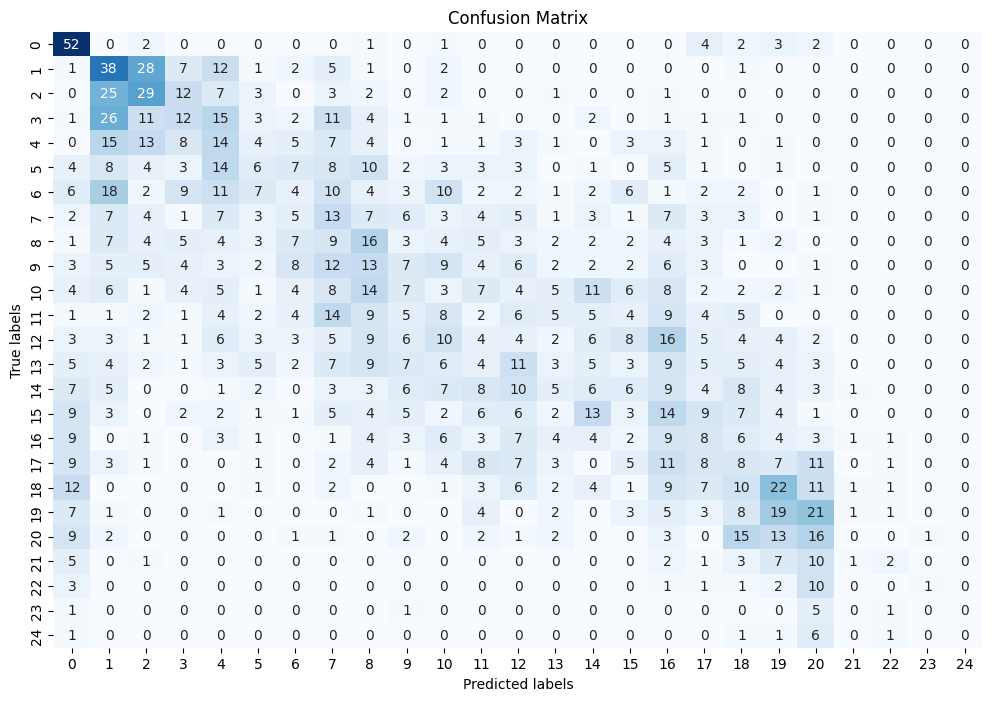

In [305]:
plot_confusion_matrix((model[1], model[2]))

### 6.4. Feature importance

In [306]:
feature_imp_serie = pd.Series(model[0].get_booster().get_fscore()).sort_values(ascending=False)

In [307]:
analysing_feature_importance(feature_imp_serie)

## 7. Test the model with specifics data

In [308]:
df_to_predict_later

,driverId,constructorId,race_rank,statusId,year,round,circuitId,constructor_is_active,constructor_races_won,constructor_avg_point,...,grid_15,grid_16,grid_17,grid_18,grid_19,grid_20,grid_21,grid_22,grid_23,grid_24
0,0,0,2,0,0.983980,1,0,1,0.024502,0.001649,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,1,3,0,0.997069,1,0,0,0.000993,0.001092,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,2,5,0,0.994097,1,0,1,0.003465,0.001110,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,3,7,0,0.984850,1,0,0,0.006866,0.001107,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,0,1,0,0.999102,1,0,1,0.024878,0.001674,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,5,2,14,10,0.999771,1,0,1,0.003485,0.001117,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,6,4,12,4,0.999724,1,0,0,0.000498,0.000464,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,7,5,4,4,0.984106,1,0,1,0.045088,0.002129,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,8,1,9,3,0.999090,1,0,0,0.000995,0.001095,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,9,6,13,2,0.999649,1,0,0,0.001493,0.000495,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [309]:
model[0].predict(df_to_predict_later.drop('race_rank', axis=1))

array([ 2,  7,  6,  3,  7, 17, 16,  1,  0,  0, 19, 16,  1,  0, 14],
      dtype=int32)